# ORIE 4580/5580/5581 Assignment 3

#### Students: Boqian Niu (bn287)

### Github link: (https://github.com/NBQian/ORIE-5581/blob/main/HW3.ipynb)

(**Please replace this with your own link!**)

### Instructions


* Due Thursday September 25, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 7 (you can skim through this), and chapters 8 and 9 of [Introduction to Probability](https://chance.dartmouth.edu/teaching_aids/books_articles/probability_book/book.html) by Grinstead and Snell.

Chapter 3 and chapter 4 (up to section 4.5) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

In [1]:
#importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

<hr><hr>

## Question 1: Combining LCGs (20 points)

In order to avoid biases, simulations should not use anywhere near the full period of an LCG (otherwise, the random sequence repeats\ldots). For example, a typical traffic simulator may have $10,000$ vehicles, each experiencing thousands of random disturbances, thus needing around $10^7$ random samples per replication -- for this, an LCG using $m=2^{31}-1\approx 2\times 10^9$ is insufficient, as after $100$ replications the sequences get correlated.

One method to combine multiple LCGs to obtain a generator with a longer period is to add a smaller period LCG to it. For example, suppose we have two generators $X_{n+1}  =  (a_1 X_n) \mbox{ mod } m_1$ and $Y_{n+1}  =  (a_2 Y_n) \mbox{ mod } m_2$, with $m_1>m_2$. We can derive a combined generator by setting $Z_n  =  (X_n + Y_n) \mbox{ mod } m_1$. If properly designed, the resulting period can be on the order of $m_1m_2$. We will now study a small example to see how this works.


<hr>

**(a)** Consider two LCGs, $x_{n+1} = (5 x_n) \mod 16$ and $y_{n+1} = (2 y_n) \mod 7$. Starting both with seed $x_0 = y_0 = 1$, plot the sequences $x_n, y_n$ using the clock visualization introduced in class (separate plot for each sequence; you can use and modify the code in Demo-PRNGs.ipynb on Canvas).

<hr>

In [12]:
# Functions to visualize LCG sequence on clock (see demo notebook)
def plot_clock(seq, m, title=""):
    theta = 2*np.pi*np.arange(m)/m
    xs, ys = np.cos(theta), np.sin(theta)
    fig, ax = plt.subplots(figsize=(4,4))
    ax.add_artist(plt.Circle((0,0),1,fill=False))
    ax.scatter(xs, ys, s=20)
    for i, k in enumerate(seq):
        ax.scatter(xs[k], ys[k], c="r", s=40)
        if i < len(seq)-1:
            ax.annotate("", (xs[seq[i+1]], ys[seq[i+1]]), (xs[k], ys[k]),
                        arrowprops=dict(arrowstyle="->"))
    ax.set_aspect("equal"); ax.axis("off"); ax.set_title(title)
    plt.show()

In [13]:
# Function to generate pseudorandom sequence using LCG
# Set default parameters to glibc specifications (see demo notebook)
def LCG_seq(seed, a, m):
    seq, x = [seed], seed
    while True:
        x = (a*x) % m
        if x == seed: break
        seq.append(x)
    return seq

x_n: [1, 5, 9, 13]
y_n: [1, 2, 4]


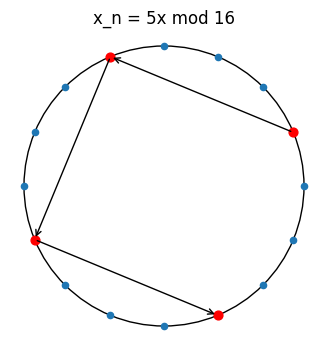

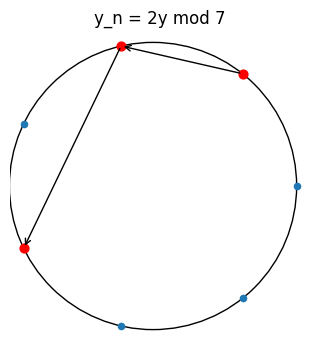

In [14]:
# Ans
x_seq = LCG_seq(1, a=5, m=16)
y_seq = LCG_seq(1, a=2, m=7)
print("x_n:", x_seq)
print("y_n:", y_seq)
plot_clock(x_seq, m=16, title="x_n = 5x mod 16")
plot_clock(y_seq, m=7,  title="y_n = 2y mod 7")

<hr>

**(b)** Next, define a combined LCG as $z_{n} = (x_n+y_n) \mod 16$. Starting both the base LCGs with seed $x_0 = y_0 = 1$, plot the sequence $z_n$ using the clock visualization given in class.

<hr>

z_n: [2, 7, 13, 14, 3, 9, 10, 15, 5, 6, 11, 1] Period: 12


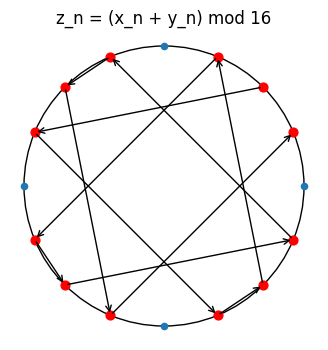

In [15]:
x_seq = LCG_seq(seed=1, a=5, m=16)
y_seq = LCG_seq(seed=1, a=2, m=7)

T = np.lcm(len(x_seq), len(y_seq))
z_seq = [ (x_seq[n % len(x_seq)] + y_seq[n % len(y_seq)]) % 16 for n in range(T) ]

print("z_n:", z_seq, "Period:", len(z_seq))
plot_clock(z_seq, m=16, title="z_n = (x_n + y_n) mod 16")

___
**(c)** What are the periods of the pseudo-random sequences $x_n, y_n$ and $z_n$?
___

### Ans.

From the outputs, the periods are 4, 3, 12 respectively.


___
___
## Question 2: inverting cdfs (25 pts)

In class, we defined $F^{-1}(y)$ for a continuous increasing cdf $F(x)$ as the unique $x$ such that $F(x) = y$ (for $y\in[0,1]$). More generally, for any cdf $F$ we can use the inversion method based on its generalized inverse or *pseudoinverse*:
	$$F^{-1}(y) = \inf\{x|F(x)\geq y\}$$
	(where $\inf$ denotes the \href{https://en.wikipedia.org/wiki/Infimum_and_supremum}{infimum}; if you have not seen this before, treat it as minimum).


___
**(a)** Find the pseudoinverse $F^{-1}(y)$ for the following mixed (discrete/continuous) cdf
	$$F(x)=
	\begin{cases}
	0 & \mbox{for $x < 0$}\\
	x & \mbox{for $0 \leq x < \frac{1}{2}$}, \\
	\frac{1}{2} & \mbox{for $\frac{1}{2}\leq x < 1$}, \\
	1 & \mbox{for $x\geq 1$}
	 \end{cases}$$
___

### Ans.
$$
F^{-1}(y)=
\begin{cases}
y, & 0<y<\tfrac{1}{2},\\[6pt]
\tfrac{1}{2}, & y=\tfrac{1}{2},\\[6pt]
1, & \tfrac{1}{2}<y\le 1.
\end{cases}
$$

___
**(b)** Use the above definition to get an inversion algorithm for the $Geometric(p)$ distribution (with pmf $p(k) = p(1-p)^{k-1}\,\forall\,k\in\{1,2,3,\ldots\}$). Implement this, and generate and plot the histogram of 1000 samples from a $Geometric(0.42)$ distribution.
(For this, it may be useful for you to first understand how the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) library works, and in particular, how it provides methods to compute various statistics for many different random variables, including the [geometric r.v.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.geom.html#scipy.stats.geom))
___

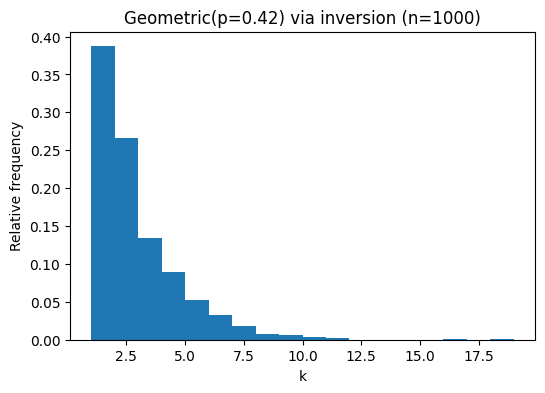

In [19]:
def geom_inv(p, n):
    u = np.random.rand(n)
    return 1 + np.floor(np.log(1 - u) / np.log(1 - p)).astype(int)

p = 0.42
samples = geom_inv(p, 1000)

plt.figure(figsize=(6,4))
plt.hist(samples, bins=np.arange(1, samples.max()+2), density=True)
plt.title("Geometric(p=0.42) via inversion (n=1000)")
plt.xlabel("k")
plt.ylabel("Relative frequency")
plt.show()

___
**(c)** The p.d.f. of the random variable $X$ is given by
	$$
	f(x) =
	\begin{cases}
		e^{x-2} & \text{for }0 \leq x \leq 2, \\
		e^{-x} & \text{for }x > 2, \\
		0 & \text{otherwise,}
	\end{cases}
	$$
	Describe and implement an inversion algorithm to generate samples of $X$. Generate 1,000 samples and plot a histogram. Compare the histogram and the p.d.f.


___

### Ans.

For
$$0 \le x \le 2,$$
$$
F(x)=\int_{0}^{x} e^{t-2}\,dt
= e^{x-2}-e^{-2}.
$$

For
$$x>2,$$
$$
F(x)=F(2)+\int_{2}^{x} e^{-t}\,dt
=(1-e^{-2})+(e^{-2}-e^{-x})
=1-e^{-x}.
$$

Thus
$$
F(x)=
\begin{cases}
0, & x<0,\\
e^{x-2}-e^{-2}, & 0 \le x \le 2,\\
1-e^{-x}, & x>2.
\end{cases}
$$



Let \(U\) be uniform on \([0,1]\) and define
$$
p_0 = F(2)=1-e^{-2}.
$$

If
$$U \le p_0,$$
then
$$
U=e^{x-2}-e^{-2}
\;\Rightarrow\;
x=2+\ln\!\big(U+e^{-2}\big).
$$

If
$$U > p_0,$$
then
$$
U=1-e^{-x}
\;\Rightarrow\;
x=-\ln(1-U).
$$

Thus,
$$
X=
\begin{cases}
2+\ln\!\big(U+e^{-2}\big), & U \le 1-e^{-2},\\[6pt]
-\ln(1-U), & U > 1-e^{-2}.
\end{cases}
$$

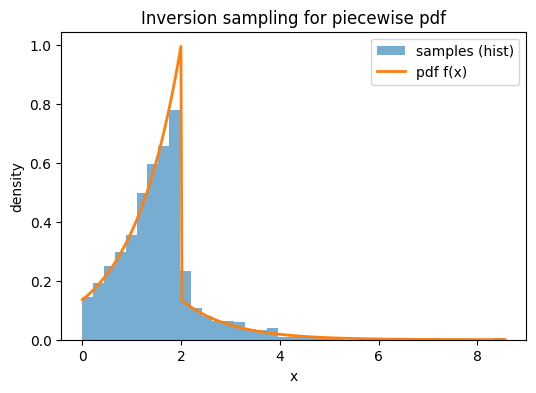

In [21]:
import numpy as np
import matplotlib.pyplot as plt

e_m2 = np.exp(-2.0)
p0 = 1.0 - e_m2

def sample_X(n):
    u = np.random.rand(n)
    x = np.empty(n)
    left = u <= p0
    x[left]  = 2.0 + np.log(u[left] + e_m2)
    x[~left] = -np.log(1.0 - u[~left])
    return x

def f_pdf(x):
    x = np.asarray(x)
    out = np.zeros_like(x, dtype=float)
    mask1 = (0 <= x) & (x <= 2)
    mask2 = (x > 2)
    out[mask1] = np.exp(x[mask1] - 2.0)
    out[mask2] = np.exp(-x[mask2])
    return out

np.random.seed(0)
n = 1000
samples = sample_X(n)
plt.figure(figsize=(6,4))
bins = np.linspace(0, max(6, samples.max()), 40)
plt.hist(samples, bins=bins, density=True, alpha=0.6, label="samples (hist)")

xx = np.linspace(0, bins[-1], 400)
plt.plot(xx, f_pdf(xx), lw=2, label="pdf f(x)")

plt.xlabel("x"); plt.ylabel("density")
plt.title("Inversion sampling for piecewise pdf")
plt.legend()
plt.show()

<hr><hr>

## Question 3: Acceptance-Rejection (25 pts)

Let the random variable $X$ have density
$$f(x) = \begin{cases} (5 x^4 + 4x^3 + 3x^2+1)/4  & \text{ for } 0 \leq x \leq 1, \\
0 & \text{ otherwise. } \end{cases}$$

<hr>

**(a)** Give an acceptance-rejection algorithm to generate samples of
	$X$.

<hr>

### Ans.


Use the uniform proposal on [0,1]:
$$
g(x)=1,\quad 0\le x\le 1.
$$

Since $f(x)$ is increasing on $[0,1]$, the maximum of $f$ occurs at $x=1$:
$$
f(1)=\frac{5+4+3+1}{4}=\frac{13}{4}.
$$
Choose $M=\frac{13}{4}$ so that $f(x)\le M\,g(x)$ for all $x\in[0,1]$.

Acceptance–rejection algorithm:
1. Draw $X\sim \text{Uniform}(0,1)$ and $U\sim \text{Uniform}(0,1)$ independently.
2. Compute
   $$
   a(X)=\frac{f(X)}{M\,g(X)}=\frac{ \frac{5X^4+4X^3+3X^2+1}{4} }{13/4}
   =\frac{5X^4+4X^3+3X^2+1}{13}.
   $$
3. If $U \le a(X)$, accept and output $X$; else reject and go back to step 1.

In [22]:
def sample_X_ar(n):
    M = 13/4
    out = []
    while len(out) < n:
        x = np.random.rand()
        u = np.random.rand()
        accept_prob = (5*x**4 + 4*x**3 + 3*x**2 + 1) / 13.0
        if u <= accept_prob:
            out.append(x)
    return np.array(out)

<hr>

**(b)** On average, how many samples from the uniform distribution over $[0, 1]$ would your acceptance-rejection algorithm need in order to generate one sample of $X$?

<hr>

### Ans.

Since the acceptance probability is
$\frac{4}{13},$
the expected number of samples needed to generate one sample of \(X\) is

$
\frac{1}{4/13} = \frac{13}{4} = 3.25.
$

<hr>

**(c)** Use your algorithm in (a) to generate 2,500 samples of $X$. Note that this will require more than 2500 uniform random variables.

Plot a histogram of your sample   and compare it against the true pdf.

<hr>

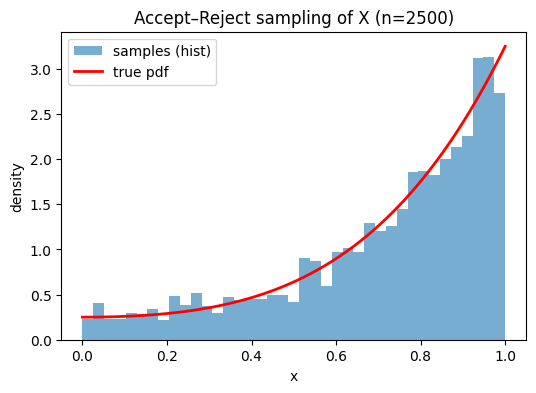

In [26]:
np.random.seed(42)
n = 2500
xs = sample_X_ar(n)

def f_pdf(x):
    return (5*x**4 + 4*x**3 + 3*x**2 + 1) / 4.0

bins = np.linspace(0, 1, 40)
plt.figure(figsize=(6,4))
plt.hist(xs, bins=bins, density=True, alpha=0.6, label="samples (hist)")
xx = np.linspace(0, 1, 400)
plt.plot(xx, f_pdf(xx), 'r-', lw=2, label="true pdf")
plt.xlabel("x")
plt.ylabel("density")
plt.title("Accept–Reject sampling of X (n=2500)")
plt.legend()
plt.show()

<hr><hr>

## Question 4: Generalized Acceptance-Rejection (30 pts)

We want to generate a $\mathcal{N}(0,1)$ rv $X$, with pdf
$f(x) = \frac{e^{-x^2/2}}{\sqrt{2\pi}} $,
using generalized acceptance-rejection.

<hr>

**(a)** First, suppose we choose the proposal distribution to be a \emph{Laplace} (i.e., two-sided Exponential) distribution, which has pdf $g(x) = e^{-|x|}/2$. Describe (and implement) an inversion algorithm to get samples from this distribution.

<hr>

For $x \le 0$:

$$
G(x) = \int_{-\infty}^{x} \tfrac{1}{2} e^{t}\,dt = \tfrac{1}{2} e^{x}.
$$

For $x \ge 0$:

$$
G(x) = 1 - \tfrac{1}{2} e^{-x}.
$$


Let $U \sim \text{Uniform}(0,1)$. Then

$$
X =
\begin{cases}
\ln(2U), & 0 < U \le \tfrac{1}{2}, \\
-\ln\!\big(2(1-U)\big), & \tfrac{1}{2} < U < 1.
\end{cases}
$$

In [27]:
def laplace_inv(n):
    u = np.random.rand(n)
    x = np.empty(n)
    left = u <= 0.5
    x[left]  = np.log(2*u[left])
    x[~left] = -np.log(2*(1 - u[~left]))
    return x

<hr>

**(b)** Determine the smallest $k$ such that $kg(x)\geq f(x)\,\forall\,x\in\mathbb{R}$. Using this, propose (and implement) an acceptance-rejection algorithm for sampling $X\sim\mathcal{N}(0,1)$, and compute the expected number of samples needed for generating each sample.

<hr>

### Ans.
Consider
$$
\frac{f(x)}{g(x)}
=\frac{ \frac{1}{\sqrt{2\pi}}e^{-x^2/2} }{ \tfrac12 e^{-|x|} }
=\sqrt{\frac{2}{\pi}}\; e^{-x^2/2+|x|}
=\sqrt{\frac{2}{\pi}}\; e^{-\frac{(|x|-1)^2}{2}+\frac12}.
$$
This is maximized at $|x|=1$, so
$$
k^\star=\sup_x \frac{f(x)}{g(x)}
=\sqrt{\frac{2e}{\pi}}
\approx 1.315.
$$

Acceptance–rejection with Laplace proposal

1. Draw $Y\sim \text{Laplace}(0,1)$ via inverse-CDF:
   $$
   Y=
   \begin{cases}
   \ln(2U_1), & U_1\le \tfrac12,\\
   -\ln\!\big(2(1-U_1)\big), & U_1> \tfrac12,
   \end{cases}
   \quad U_1\sim \text{Unif}(0,1).
   $$
2. Draw $U_2\sim \text{Unif}(0,1)$ and accept $Y$ as $X$ if
   $$
   U_2 \le \frac{f(Y)}{k^\star g(Y)}.
   $$
   Otherwise, reject and repeat.

Acceptance probability $=1/k^\star \approx 0.761$.  
Expected #proposals per accepted sample $=k^\star \approx 1.315$.  
If counting uniforms, each proposal uses two uniforms (one for $Y$, one for the test), so expected uniforms per accepted sample $\approx 2k^\star \approx 2.63$.

In [28]:
def laplace_inv(n):
    u = np.random.rand(n)
    x = np.empty(n)
    left = (u <= 0.5)
    x[left]  = np.log(2*u[left])
    x[~left] = -np.log(2*(1 - u[~left]))
    return x

def f_norm(x):
    return np.exp(-0.5*x**2) / np.sqrt(2*np.pi)

def g_laplace(x):
    return 0.5*np.exp(-np.abs(x))

k_star = np.sqrt(2*np.e/np.pi)

def sample_normal_via_AR(n):
    out = []
    while len(out) < n:
        y = laplace_inv(1)[0]
        u = np.random.rand()
        if u <= f_norm(y) / (k_star * g_laplace(y)):
            out.append(y)
    return np.array(out)

<hr>

**(c)** Generate $1000$ samples from your method in part (b), and plot the histogram of the samples. Also report the average and 95\% CI for the number of $U[0,1]$ samples needed to generate the $1000$ samples.

<hr>

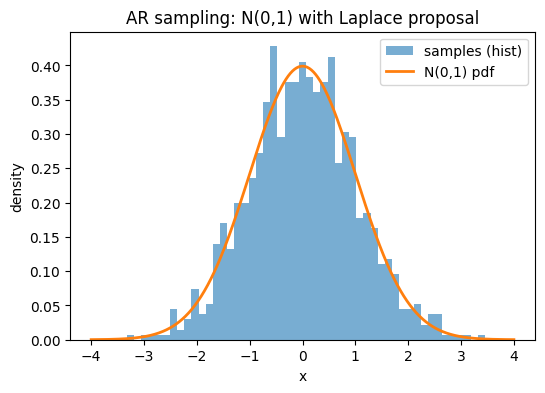

Empirical uniforms used: 2720  (~2.720 per sample)
Theoretical mean uniforms for n=1000: 2631.0
95% CI for total uniforms: [2551.1, 2710.8]


In [30]:
np.random.seed(0)
n = 1000
xs, uniforms_used = sample_normal_via_AR_count(n)

bins = np.linspace(-4, 4, 60)
plt.figure(figsize=(6,4))
plt.hist(xs, bins=bins, density=True, alpha=0.6, label="samples (hist)")
xx = np.linspace(-4, 4, 400)
plt.plot(xx, f_norm(xx), lw=2, label="N(0,1) pdf")
plt.xlabel("x"); plt.ylabel("density"); plt.title("AR sampling: N(0,1) with Laplace proposal")
plt.legend(); plt.show()
emp_mean_uniforms_per_sample = uniforms_used / n

p = 1.0 / k_star
mean_T = n / p
var_T  = n * (1 - p) / p**2
mean_uniforms_total = 2 * mean_T
sd_uniforms_total   = 2 * np.sqrt(var_T)
ci_lo = mean_uniforms_total - 1.96 * sd_uniforms_total
ci_hi = mean_uniforms_total + 1.96 * sd_uniforms_total

print(f"Empirical uniforms used: {uniforms_used}  (~{emp_mean_uniforms_per_sample:.3f} per sample)")
print(f"Theoretical mean uniforms for n={n}: {mean_uniforms_total:.1f}")
print(f"95% CI for total uniforms: [{ci_lo:.1f}, {ci_hi:.1f}]")

<hr>

**(d)** Now, suppose instead we choose the proposal distribution to be a Cauchy  distribution with pdf $g(x) = \frac{1}{\pi(1+x^2)}$. Describe and implement an inversion algorithm to get samples from this distribution, and plot the histogram of 1000 samples from this distribution.

<hr>

$$
G(x)=\int_{-\infty}^{x}\frac{1}{\pi(1+t^2)}\,dt
= \frac{1}{\pi}\arctan(x)+\tfrac12.
$$

Let $U\sim\text{Uniform}(0,1)$. Solve $U=G(x)$:
$$
U = \tfrac{1}{\pi}\arctan(x)+\tfrac12
\;\Longrightarrow\;
x = \tan\!\big(\pi(U-\tfrac12)\big).
$$

Thus the inversion sampler is:
$$
X=\tan\!\big(\pi(U-\tfrac12)\big),\quad U\sim\text{Uniform}(0,1).
$$

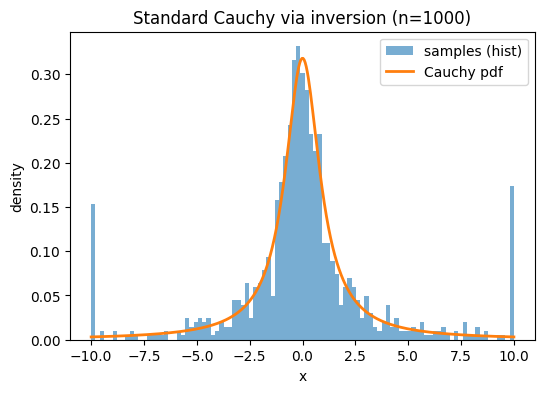

In [31]:
def cauchy_inv(n):
    u = np.random.rand(n)
    return np.tan(np.pi*(u - 0.5))

np.random.seed(0)
samples = cauchy_inv(1000)

plt.figure(figsize=(6,4))
bins = np.linspace(-10, 10, 100)
plt.hist(np.clip(samples, bins[0], bins[-1]), bins=bins, density=True, alpha=0.6, label="samples (hist)")

x = np.linspace(-10, 10, 400)
pdf = 1/(np.pi*(1 + x**2))
plt.plot(x, pdf, lw=2, label="Cauchy pdf")
plt.xlabel("x"); plt.ylabel("density"); plt.title("Standard Cauchy via inversion (n=1000)")
plt.legend(); plt.show()

<hr>

**(e)** Repeat parts $(b)$ and $(c)$ for this proposal distribution.

<hr>

### Ans.

Consider
$$
\frac{f(x)}{g(x)}
= \frac{\frac{1}{\sqrt{2\pi}} e^{-x^2/2}}{\frac{1}{\pi(1+x^2)}}
= \frac{\pi}{\sqrt{2\pi}} (1+x^2) e^{-x^2/2}
= \sqrt{\tfrac{\pi}{2}} \,(1+x^2) e^{-x^2/2}.
$$

Let $t = x^2 \ge 0$. Define $h(t) = (1+t)e^{-t/2}$.  
Its derivative is
$$
h'(t) = \tfrac{1}{2} e^{-t/2}(1-t),
$$
which is zero at $t=1$ (i.e. $|x|=1$). This gives the maximum.

Thus
$$
k^* = \sup_x \frac{f(x)}{g(x)}
= \sqrt{\tfrac{\pi}{2}} \cdot 2 e^{-1/2}
= \sqrt{\tfrac{2\pi}{e}}
\approx 1.520.
$$

Acceptance–Rejection with Cauchy proposal

1. Draw $Y \sim \text{Cauchy}(0,1)$ via inverse CDF:
   $$
   Y = \tan\!\big(\pi(U_1 - \tfrac{1}{2})\big), \quad U_1 \sim \text{Uniform}(0,1).
   $$
2. Draw $U_2 \sim \text{Uniform}(0,1)$ and accept $Y$ as $X$ if
   $$
   U_2 \le \frac{f(Y)}{k^* g(Y)}.
   $$
   Otherwise reject and repeat.


- Acceptance probability:  
  $$
  \frac{1}{k^*} = \sqrt{\tfrac{e}{2\pi}} \approx 0.658.
  $$
- Expected proposals per accepted sample:  
  $$
  k^* \approx 1.520.
  $$
- Expected number of uniforms per accepted sample:  
  $$
  2k^* \approx 3.04.
  $$

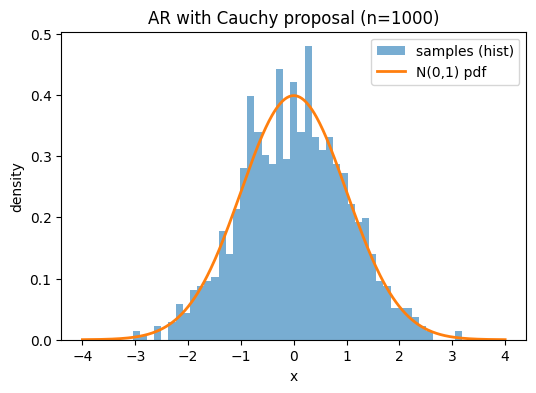

Empirical uniforms used: 3132  (~3.132 per sample)
Theoretical mean uniforms: 3040.7
95% CI (theoretical) for total uniforms: [2930.4, 3151.0]


In [34]:
def f_norm(x):
    return np.exp(-0.5*x**2) / np.sqrt(2*np.pi)

def g_cauchy(x):
    return 1.0 / (np.pi*(1 + x**2))

k_star = np.sqrt(2*np.pi/np.e)

def sample_normal_AR_cauchy(n, count_uniforms=True):
    out, uniforms = [], 0
    while len(out) < n:
        y = cauchy_inv(1)[0]; uniforms += 1
        u = np.random.rand();  uniforms += 1
        if u <= f_norm(y) / (k_star * g_cauchy(y)):
            out.append(y)
    return np.array(out), uniforms

np.random.seed(0)
n = 1000
xs, uniforms_used = sample_normal_AR_cauchy(n)

bins = np.linspace(-4, 4, 60)
plt.figure(figsize=(6,4))
plt.hist(xs, bins=bins, density=True, alpha=0.6, label="samples (hist)")
xx = np.linspace(-4, 4, 400)
plt.plot(xx, f_norm(xx), lw=2, label="N(0,1) pdf")
plt.xlabel("x"); plt.ylabel("density"); plt.title("AR with Cauchy proposal (n=1000)")
plt.legend(); plt.show()

print(f"Empirical uniforms used: {uniforms_used}  (~{uniforms_used/n:.3f} per sample)")
print(f"Theoretical mean uniforms: {2*n*k_star:.1f}")

p = 1.0 / k_star
mean_T = n / p
var_T  = n * (1 - p) / p**2
mean_uniforms_total = 2 * mean_T
sd_uniforms_total   = 2 * np.sqrt(var_T)
ci_lo = mean_uniforms_total - 1.96 * sd_uniforms_total
ci_hi = mean_uniforms_total + 1.96 * sd_uniforms_total
print(f"95% CI (theoretical) for total uniforms: [{ci_lo:.1f}, {ci_hi:.1f}]")